In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
!pip install collection
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, WordPunctTokenizer, word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
import string, re, os, warnings
#from collections import Collection, Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment import SentimentAnalyzer, SentimentIntensityAnalyzer
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable


In [2]:
df = pd.read_csv('airline.csv')
df.sample(5)

Air_ailine
809   ‚úÖTrip Verified|  Gatwick to Tirana. I was incr...
3694  10th July BA117 LHR-JFK. Well I have not flown...
3019  Recently flew BA from LHR to ORD, 64A, Upper D...
3295  Flew AMS-LHR-JFK return 26th Dec - 31st Dec. A...
1808  ‚ùéUnverified|  London to Reykjavik. I can't rea...

In [3]:
df['Air_ailine'][:1]

0    Not Verified|  My wife and I are very disappoi...
Name: Air_ailine, dtype: object

In [4]:
df.shape, df.dtypes, df.isnull().sum()

((3861, 1),
 Air_ailine    object
 dtype: object,
 Air_ailine    0
 dtype: int64)

In [5]:
### longueur des commentaires
def length_text(text):
    text = text.split(" ")
    long = len(text)
    return long

df['length_avis'] = df['Air_ailine'].apply(lambda i : length_text(i))
df.sample(10).max()

Air_ailine     ‚ùéNot Verified| London to Olbia. Complete confu...
length_avis                                                  362
dtype: object

In [6]:
df.describe().T

count        mean         std   min   25%    50%    75%    max
length_avis  3861.0  163.085729  107.257511  15.0  87.0  135.0  206.0  657.0

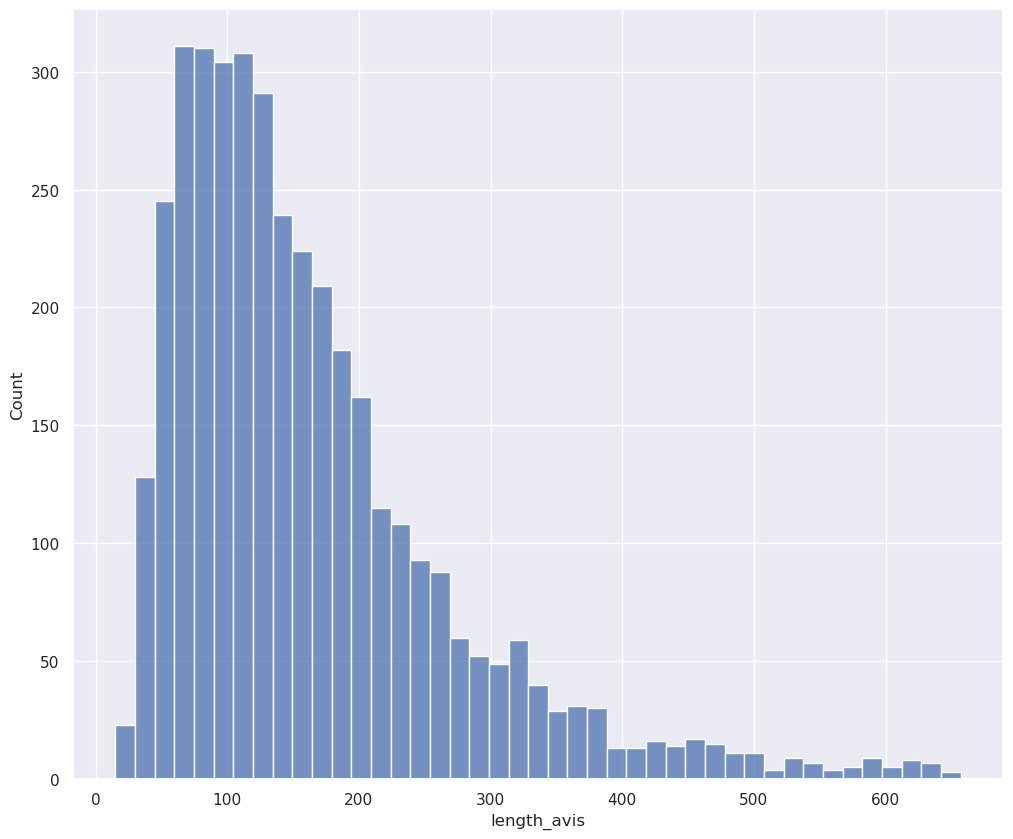

In [7]:
sns.set()
plt.figure(figsize = (12, 10))
sns.histplot(data = df, x = df['length_avis'])
plt.show()

# Pr√©-traitement des avis 

### Nettoyage des urls , emojis, caract√®res speciaux, des lien htmls etc...

In [8]:
def clean_text(text):
    ### normaliser la tailles des textes
    text = text.lower()
    ## suppression des caracteres speciaux et autres 
    text = re.sub("\[.*?\]", '', text)
    #supprimer les urls html, asc
    text = re.sub("https?://\S+|www\.\S+", '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub("\n", '', text)
    text = re.sub('\w*\d\w*', '', text)
    #text = re.sub('\w*\d\w*', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['airline_clean'] = df['Air_ailine'].apply(lambda x: clean_text(x))
df.sample(n = 10)

Air_ailine  length_avis  \
662   Not Verified|  What has happened to British Ai...          538   
1087  ‚úÖTrip Verified|  Madrid to London BA0457 on th...           80   
793   ‚úÖTrip Verified| I purchased roundtrip tickets ...          101   
1091  ‚úÖTrip Verified|  I had a miserable experience ...          114   
2699  I think one word sums it up 'Rubbish'. The Lon...          377   
197   Not Verified|  Awful. Business class check in ...           86   
1039  ‚úÖTrip Verified|  Lima to Gatwick. Helpful and ...           81   
1662  ‚úÖVerified Review|  Nice to London Heathrow. Yo...          215   
2659  MAD-SYD VIA LHR with British Airways. Overall ...           63   
2031  ‚úÖVerified Review|  Flew from Gatwick to Tampa ...          261   

                                          airline_clean  
662   not verified  what has happened to british air...  
1087  ‚úÖtrip verified  madrid to london  on the  coul...  
793   ‚úÖtrip verified i purchased roundtrip tickets f...  
1091  ‚úÖtrip verified  i had a miserable experience i...  
2699  i think one word sums it up rubbish the london...  
197   not verified  awful business class check in qu...  
1039  ‚úÖtrip verified  lima to gatwick helpful and co...  
1662  ‚úÖverified review  nice to london heathrow you ...  
2659  madsyd via lhr with british airways overall go...  
2031  ‚úÖverified review  flew from gatwick to tampa b...

In [9]:
def text_clean(text):
    text = text.lower()
    # Ne garde que les caract√®res alphanum√©riques, espaces et ponctuation
    text = re.sub(r'[^\w\s,.!?]', '', text)  

    # Suppression des parties 'Trip Verified' ou 'Not Verified'
    text = re.sub(r'(Trip Verified|Verified Review|Not Verified|Unverified)', '',text, flags=re.IGNORECASE).strip()
    text = re.sub("\[.*?\]", '', text)
    #supprimer les urls html, asc
    text = re.sub("https?://\S+|www\.\S+", '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub("\n", '', text)
    text = re.sub('\w*\d\w*', '', text)
    #text = re.sub('\w*\d\w*', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['text_clean'] = df['Air_ailine'].apply(text_clean)
df.sample(20)

Air_ailine  length_avis  \
717   ‚úÖTrip Verified|  I was supposed to fly with Ae...          567   
2192  ‚úÖVerified Review|  British Airways was the che...           49   
748   ‚úÖTrip Verified| Just before the borders were c...          251   
2701  London Heathrow to Brisbane via Singapore retu...          112   
192   ‚úÖTrip Verified|   The worst airline I have eve...           65   
1560  ‚úÖVerified Review|  London to New York JFK in c...          147   
2694  Flew to Kuala Lumpur with British Airways on a...          150   
935   ‚úÖTrip Verified|  London to Abu Dhabi. This is ...          115   
743   ‚úÖTrip Verified|  My wife and I used Avios and ...          157   
1340  Not Verified|  First time flying with British ...          124   
574   ‚úÖTrip Verified| Very small plane for a busy ro...           34   
995   ‚úÖTrip Verified|  Frankfurt to London. BA staff...           78   
3783  LHR to BKK in club world over night flight. Lo...           91   
3578  Flew between LHR and JFK and the return leg wa...          100   
3565  Tel Aviv to Glasgow via Heathrow. Club World o...           84   
2899  We were delayed going out from Heathrow to Ban...           80   
3672  I have used BA over the past 20 years as I cho...          183   
1011  ‚úÖTrip Verified|  Amsterdam to London on 15th A...          145   
530   ‚úÖTrip Verified|  The crew BA656 on 6 June abso...           30   
1087  ‚úÖTrip Verified|  Madrid to London BA0457 on th...           80   

                                          airline_clean  \
717   ‚úÖtrip verified  i was supposed to fly with aer...   
2192  ‚úÖverified review  british airways was the chea...   
748   ‚úÖtrip verified just before the borders were cl...   
2701  london heathrow to brisbane via singapore retu...   
192   ‚úÖtrip verified   the worst airline i have ever...   
1560  ‚úÖverified review  london to new york jfk in cl...   
2694  flew to kuala lumpur with british airways on a...   
935   ‚úÖtrip verified  london to abu dhabi this is th...   
743   ‚úÖtrip verified  my wife and i used avios and m...   
1340  not verified  first time flying with british a...   
574   ‚úÖtrip verified very small plane for a busy rou...   
995   ‚úÖtrip verified  frankfurt to london ba staff w...   
3783  lhr to bkk in club world over night flight lou...   
3578  flew between lhr and jfk and the return leg wa...   
3565  tel aviv to glasgow via heathrow club world on...   
2899  we were delayed going out from heathrow to ban...   
3672  i have used ba over the past  years as i chose...   
1011  ‚úÖtrip verified  amsterdam to london on  april ...   
530   ‚úÖtrip verified  the crew  on  june absolutely ...   
1087  ‚úÖtrip verified  madrid to london  on the  coul...   

                                             text_clean  
717   i was supposed to fly with aeroflot on the  of...  
2192  british airways was the cheapest airline when ...  
748   just before the borders were closed in south a...  
2701  london heathrow to brisbane via singapore retu...  
192   the worst airline i have ever flown with alloc...  
1560  london to new york jfk in club world after rea...  
2694  flew to kuala lumpur with british airways on a...  
935   london to abu dhabi this is the daytime flight...  
743   my wife and i used avios and my ba amex compan...  
1340  first time flying with british airways in econ...  
574   very small plane for a busy route service was ...  
995   frankfurt to london ba staff watched while sec...  
3783  lhr to bkk in club world over night flight lou...  
3578  flew between lhr and jfk and the return leg wa...  
3565  tel aviv to glasgow via heathrow club world on...  
2899  we were delayed going out from heathrow to ban...  
3672  i have used ba over the past  years as i chose...  
1011  amsterdam to london on  april i arrived  hours...  
530   the crew  on  june absolutely made this flight...  
1087  madrid to london  on the  couldnt have been a ...

### WordCloud of text avis 

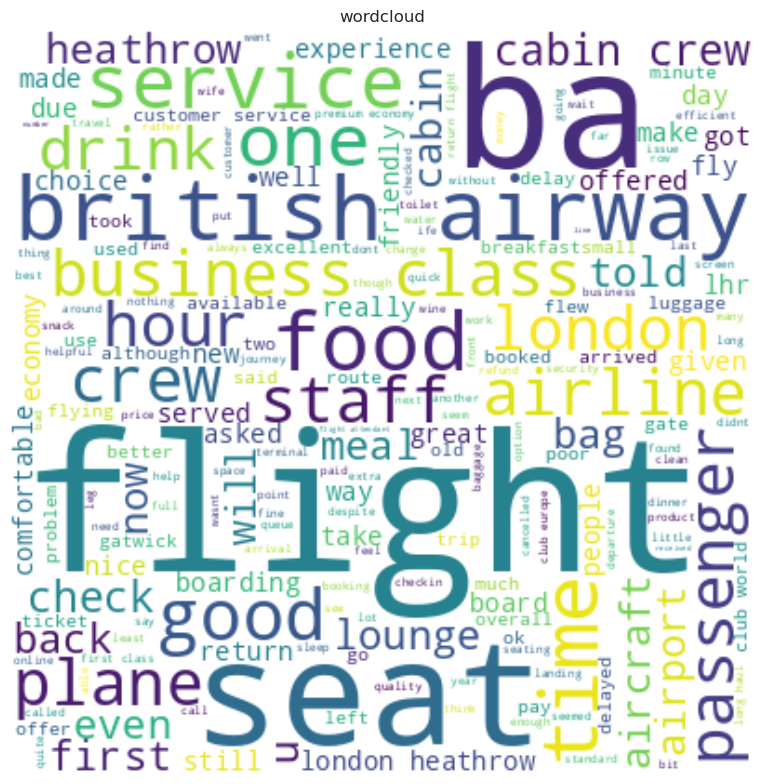

In [10]:
def get_wordcloud(text):
    text = ' '.join(text)
    word = WordCloud(width = 400, height = 400, background_color = 'white').generate(text)
    plt.figure(figsize=(12, 8))
    plt.imshow(word, interpolation='bilinear')
    plt.axis('off')
    plt.title("wordcloud")
    plt.tight_layout()
    plt.show()

get_wordcloud(df['text_clean'])

In [11]:
##Analysis sentiment of each reviews person trip

def sentiment_analysis(text):
    sentiment  = SentimentIntensityAnalyzer()
    score = sentiment.polarity_scores(text)

    if score['compound'] > 0.05:
        return 'positif'
    elif score['compound'] <-0.05:
        return 'negative'
    else:
        return 'neutre'

df['sentiment'] = df['text_clean'].apply(sentiment_analysis)
df.sample(5)

Air_ailine  length_avis  \
2812  British Airways from London to Rome, almost pe...           38   
3435  Recently flew with British Airways on Europe t...           69   
544   ‚úÖTrip Verified|  When I tried to check in, the...          265   
1687  ‚úÖVerified Review|  \r\nFlew British Airways fr...          296   
3534  Flown 6 flights on BA recently generally satis...          165   

                                          airline_clean  \
2812  british airways from london to rome almost per...   
3435  recently flew with british airways on europe t...   
544   ‚úÖtrip verified  when i tried to check in they ...   
1687  ‚úÖverified review  \rflew british airways from ...   
3534  flown  flights on ba recently generally satisf...   

                                             text_clean sentiment  
2812  british airways from london to rome almost per...   positif  
3435  recently flew with british airways on europe t...  negative  
544   when i tried to check in they required a certi...  negative  
1687  flew british airways from pisa to london gatwi...   positif  
3534  flown  flights on ba recently generally satisf...   positif

In [12]:
df.sentiment.value_counts().reset_index()

sentiment  count
0   positif   2203
1  negative   1598
2    neutre     60

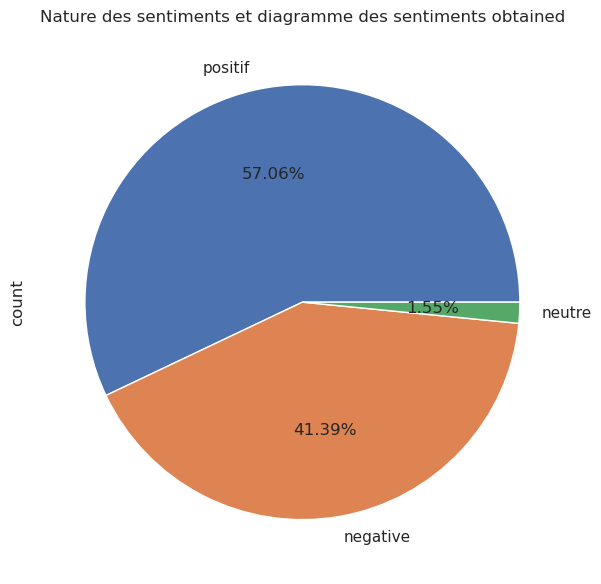

<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure(figsize=(8, 6))
df.sentiment.value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.title('Nature des sentiments et diagramme des sentiments obtained')
plt.tight_layout()
sns.set_style('white')
plt.show()
plt.savefig('circulaire_sentiment.png', format = 'png', dpi = 300)

## Visualisations des sentiments positif, negative ou neutre

Nuage de point des sentiments positive


<Figure size 640x480 with 0 Axes>

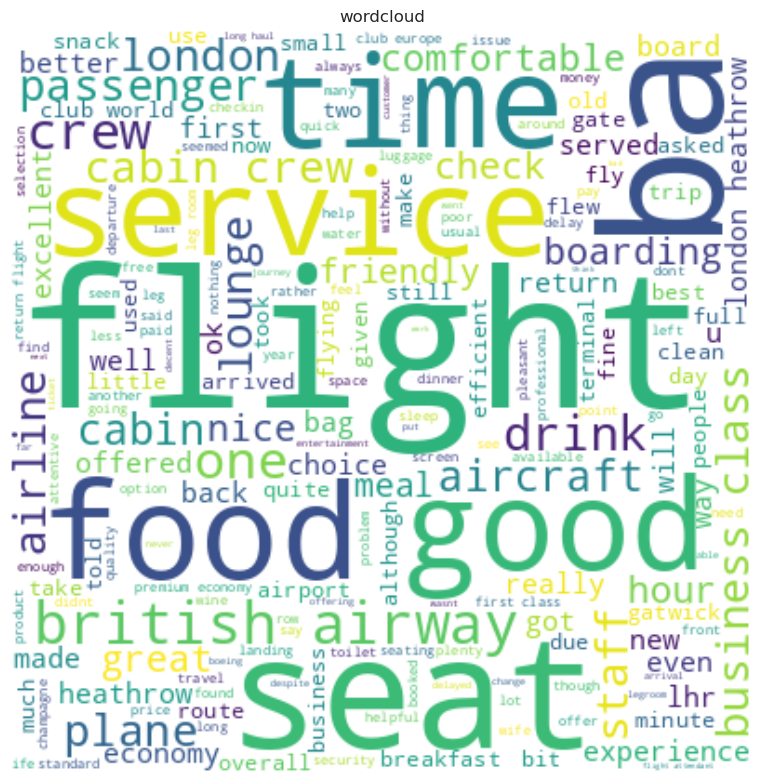

Nuage de point des sentiments negative


<Figure size 640x480 with 0 Axes>

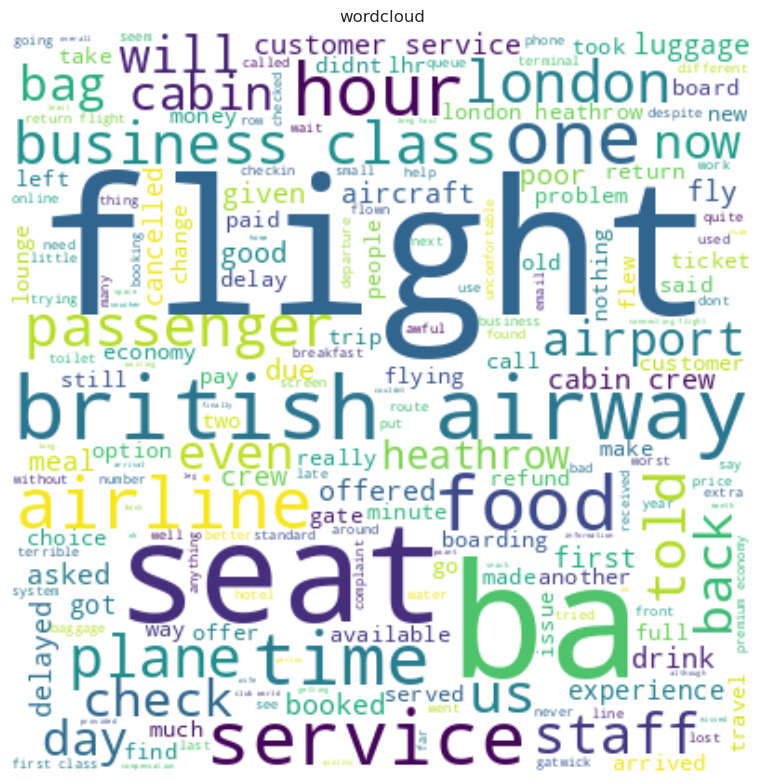

Nuage de point des sentiments neutre


<Figure size 640x480 with 0 Axes>

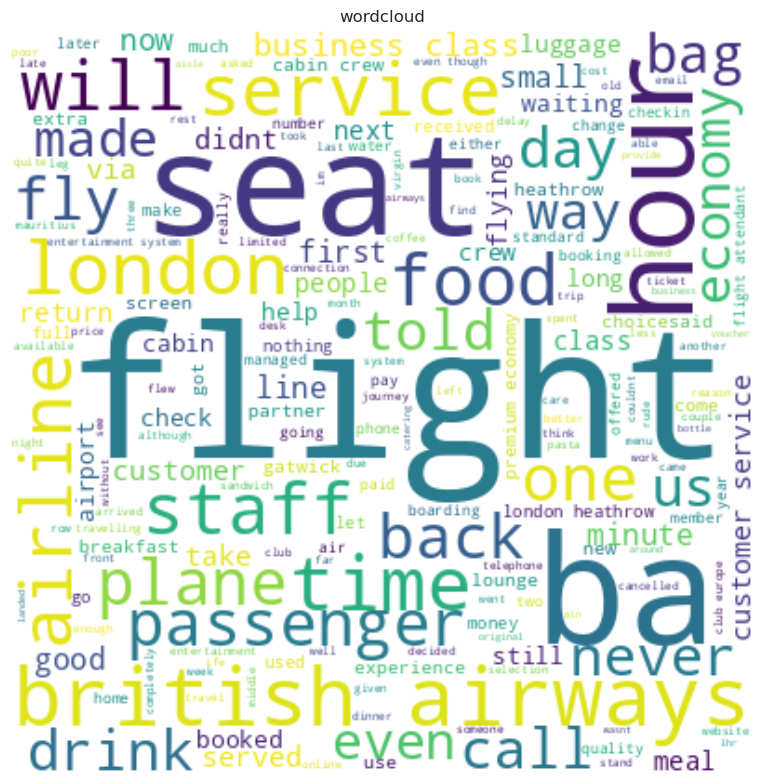

In [14]:
positive = df.loc[df['sentiment'] == 'positif', 'text_clean']
negative = df.loc[df['sentiment'] == 'negative', 'text_clean']
neutre = df.loc[df['sentiment'] == 'neutre', 'text_clean']

sentiment = [('positive', positive), ('negative', negative), 
             ('neutre', neutre)]
for label,feel in sentiment : 
    print(f"Nuage de point des sentiments {label}")
    plt.savefig('Nuage de points de {label}.png', format ='png', dpi = 300)
    get_wordcloud(feel)

In [15]:
positive

1       we flew ba between heathrow and berlin one way...
3       took a trip to nashville with my wife for a le...
6       as someone who flies relentlessly with british...
8       straightforward check in  new site for club ch...
12      although all four flights were delayed the ser...
                              ...                        
3856    lhrhkg on boeing    much has been written abou...
3857    lhr to ham purser addresses all club passenger...
3858    my son who had worked for british airways urge...
3859    london citynew york jfk via shannon on  but ha...
3860    sinlhr   first class old aircraft  with seats ...
Name: text_clean, Length: 2203, dtype: object

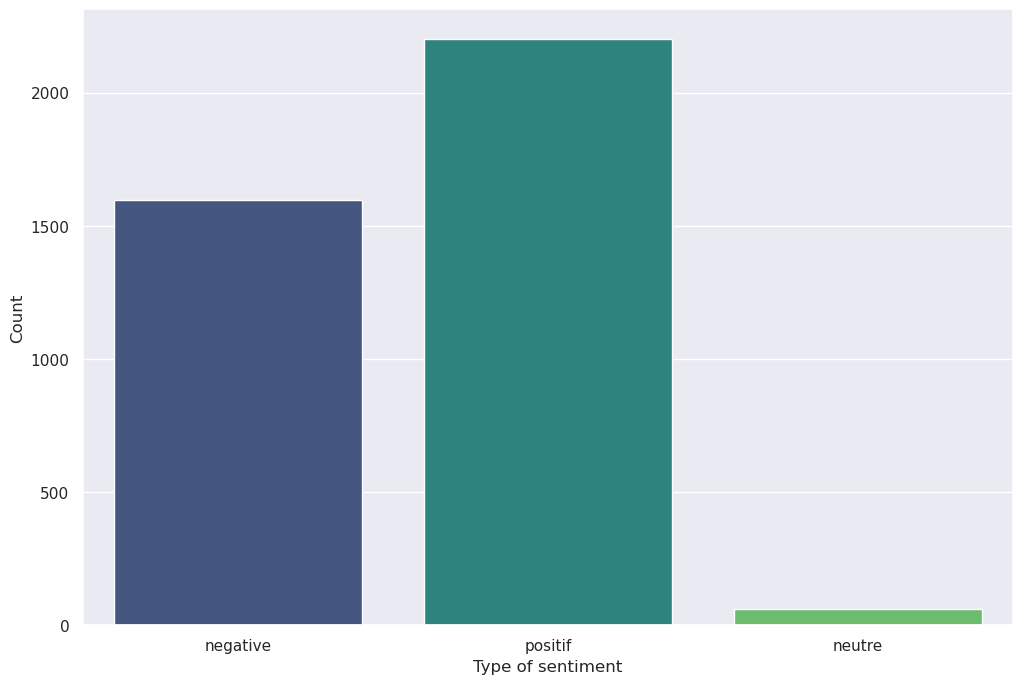

In [16]:
plt.figure(figsize=(12, 8))
sns.set()
sns.countplot(data = df, x = 'sentiment', palette = 'viridis')
sns.set_color_codes()
sns.set_style('white')
plt.xlabel('Type of sentiment')
plt.ylabel('Count')

plt.savefig(f"Diagramme.png", format = 'png', dpi = 300)
plt.show()

## Analyse des th√®mes et sujet divers dans les donn√©es

##2. Analyse des th√®mes et sujets (Topic Modeling)
Mod√®les courants :

LDA (Latent Dirichlet Allocation) : M√©thode classique non supervis√©e pour identifier les sujets.
NMF (Non-negative Matrix Factorization) : Alternative √† LDA pour extraire des th√®mes dans des jeux de donn√©es textuels.
BERTopic : Utilisation de BERT pour capturer les repr√©sentations contextuelles et regrouper les sujets automatiquement.
GPT-4 : Capable d'extraire des sujets de mani√®re contextuelle via des prompts bien con√ßus, sans avoir besoin de formation suppl√©mentaire.
Cas d'utilisation : Utilisation de BERTopic pour d√©tecter les sujets r√©currents dans des critiques de produit pour identifier des th√®mes comme "qualit√©", "livraison", "service client".

### utilisation de Bertopic pour identifier les sujets recurrents dans les avis des utilisateurs
#from bertopic import BERTopic
# from sentence_transformers import SentenceTransformer
### """pour manque de ressources , nous allons utiliser les approches solides plus ou moins efficaces 
### LDA (non supervis√©es ) et NMF pour identifier les th√®mes recurrents dans les commentaires et avis pour savoir de quoi discute vraiment les utilisateurs ou les voyageurs"""

Pour utiliser LDA (Latent Dirichlet Allocation) pour l'analyse de sujets, voici un guide √©tape par √©tape avec des exemples de code en Python en utilisant la biblioth√®que gensim et sklearn :

1 ------>>> Pr√©paration des donn√©es : Assurez-vous que vos donn√©es textuelles sont nettoy√©es et tokenis√©es.

2 ------>> Vectorisation des donn√©es : Transformez le texte en une matrice de termes.

4 ------>> Entra√Ænement du mod√®le LDA : Utilisez la matrice de termes pour entra√Æner le mod√®le LDA.

3 ------>> Analyse des r√©sultats : Interpr√©tez les th√®mes extraits par le mod√®le.



In [17]:
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models


### suppression des stopwords et tokenizer
def nettoye_text(text):
    stop_words = set(stopwords.words(['english', 'french']))
    tokenizer = word_tokenize(text)
    tokens = [word for word in tokenizer if word not in stop_words]
    return tokens

df['avis'] = df['text_clean'].apply(lambda x: nettoye_text(x))
df.sample(5)

Air_ailine  length_avis  \
3586  I have flown LHR-BKK many times with EVA Emira...          268   
1273  ‚úÖTrip Verified|  I booked a round trip from Mi...           96   
2128  ‚úÖVerified Review| Singapore to London. Having ...           87   
3752  Paphos - LGW 11th June. We had monitored the o...          244   
475   Not Verified| London to Manchester. British Ai...           42   

                                          airline_clean  \
3586  i have flown lhrbkk many times with eva emirat...   
1273  ‚úÖtrip verified  i booked a round trip from mil...   
2128  ‚úÖverified review singapore to london having no...   
3752  paphos  lgw  june we had monitored the outboun...   
475   not verified london to manchester british airw...   

                                             text_clean sentiment  \
3586  i have flown lhrbkk many times with eva emirat...  negative   
1273  i booked a round trip from milan to california...  negative   
2128  singapore to london having not flown british a...   positif   
3752  paphos  lgw  june we had monitored the outboun...   positif   
475   london to manchester british airways is probab...  negative   

                                                   avis  
3586  [flown, lhrbkk, many, times, eva, emirates, om...  
1273  [booked, round, trip, milan, california, honey...  
2128  [singapore, london, flown, british, airways, l...  
3752  [paphos, lgw, june, monitored, outbound, fligh...  
475   [london, manchester, british, airways, probabl...

In [18]:
### vectorisation
texts = df['avis'].tolist()
dico = corpora.Dictionary(texts)
word = [dico.doc2bow(text) for text in texts]

## model LDA
model = LdaModel(word, num_topics=10, id2word= dico, passes=15)
# Affichage des sujets
for idx, topic in model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}')

# Optionnel: Visualisation avec pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis

visualize = pyLDAvis.gensim_models.prepare(model, word, dico)
pyLDAvis.display(visualize)

Topic: 0 
Words: 0.058*"flight" + 0.021*"ba" + 0.014*"london" + 0.013*"hours" + 0.011*"us" + 0.010*"delayed" + 0.010*"heathrow" + 0.010*"cancelled" + 0.009*"airways" + 0.009*"british"
Topic: 1 
Words: 0.006*"masks" + 0.004*"lax" + 0.003*"social" + 0.003*"distancing" + 0.002*"versa" + 0.002*"vice" + 0.002*"busier" + 0.002*"rough" + 0.002*"colors" + 0.002*"sold"
Topic: 2 
Words: 0.024*"ba" + 0.012*"flight" + 0.011*"seats" + 0.009*"seat" + 0.009*"service" + 0.008*"staff" + 0.007*"passengers" + 0.007*"would" + 0.007*"cabin" + 0.006*"one"
Topic: 3 
Words: 0.018*"flight" + 0.013*"british" + 0.013*"airways" + 0.011*"told" + 0.011*"customer" + 0.009*"get" + 0.009*"would" + 0.008*"call" + 0.008*"us" + 0.008*"service"
Topic: 4 
Words: 0.010*"tel" + 0.010*"aviv" + 0.008*"leeds" + 0.006*"interiors" + 0.005*"cyprus" + 0.004*"buggy" + 0.004*"console" + 0.004*"ncl" + 0.003*"bradford" + 0.003*"malpensa"
Topic: 5 
Words: 0.047*"class" + 0.044*"business" + 0.031*"seat" + 0.026*"seats" + 0.021*"economy" 

In [19]:
### sauvegarder le model 
model.save('theme_recurents.gensim')

## sauvegarder les dictionnaires de mots
dico.save('dictionnary_words.dict')
## sauvegarder la visualisations

pyLDAvis.save_html(visualize, 'Recurrents_topic.html')

In [20]:
## sauvegarder le corpus
corpora.MmCorpus.serialize('corpus.mm', word)

üåü What is Bert Topic?
Le sujet Bert est une m√©thode de mod√©lisation de sujets qui utilise les mod√®les de transformation de langage, en particulier les mod√®les Bert. Ce qui est int√©ressant avec le sujet Bert, c'est qu'il fonctionne non seulement comme une m√©thode de mod√©lisation de sujets, mais il utilise √©galement des algorithmes d'apprentissage automatique pour trouver des clusters au sein d'un grand corpus de documents et regrouper automatiquement ces documents pour vous. Il pr√©sente plusieurs avantages par rapport √† la mod√©lisation traditionnelle des sujets bas√©e sur l'allocation de Dirichlet latente (LDA), qui est la m√©thode d'origine de la mod√©lisation des sujets en traitement automatique du langage naturel (TALN) et dans les sciences. L'avantage le plus important est qu'il peut incorporer vos documents avant de trouver des motifs parmi eux, et nous parlerons de l'incorporation dans un Instant. L'autre avantage du sujet Bert est qu'il vous permet √©galement de g√©n√©rer automatiquement le nombre de sujets, ce qui est une sp√©cification requise pour la plupart des algorithmes LDA.

üî• Advantages of Bert Topic
Le sujet Bert pr√©sente plusieurs avantages par rapport aux approches traditionnelles de mod√©lisation des sujets, telle que l'allocation de Dirichlet latente (LDA) :

Utilisation de puissants mod√®les de langage : Le sujet Bert utilise les mod√®les de langage de transformation, notamment les mod√®les Bert, pour cr√©er des repr√©sentations s√©mantiques profondes des documents. Cela permet une meilleure analyse des similitudes s√©mantiques entre les documents.

Repr√©sentations num√©riques riches : En utilisant le mod√®le Bert, le sujet Bert peut incorporer des mots cl√©s tels que "under" qui sont g√©n√©ralement supprim√©s dans d'autres approches de mod√©lisation des sujets. Cela permet de capturer des informations plus riches et un contexte plus large des mots dans les documents.

Classification automatique des documents : Le sujet Bert utilise des algorithmes d'apprentissage automatique pour trouver des clusters de documents dans un corpus et les regrouper automatiquement. Cela √©limine le besoin de sp√©cifier manuellement le nombre de sujets dans le mod√®le.

Visualisation des clusters de documents : Le sujet Bert permet de visualiser les clusters de documents dans un format facile √† comprendre, ce qui facilite l'analyse des r√©sultats et la d√©couverte de motifs.

üåü Getting Started with Bert Topic
Pour commencer avec le sujet Bert, vous devez suivre les √©tapes suivantes :

1. Installation de Bert Topic
Tout d'abord, installez le sujet Bert en utilisant la commande suivante :

pip install bertopic
Assurez-vous d'avoir pandas install√© √©galement, car nous l'utiliserons pour manipuler et afficher les donn√©es.

2. Chargement et pr√©traitement des donn√©es
Ensuite, vous devez charger vos donn√©es pour les pr√©parer √† √™tre utilis√©es avec le sujet Bert. Assurez-vous d'avoir un fichier JSON contenant vos documents. Vous pouvez charger les donn√©es √† l'Aide de la biblioth√®que json comme ceci :

import json

with open('data.json') as f:
    data = json.load(f)

docs = data['docs']  # Assurez-vous que la cl√© 'docs' correspond √† vos donn√©es de documents
3. Entra√Ænement du mod√®le Bert Topic
Une fois vos donn√©es charg√©es, vous pouvez cr√©er et entra√Æner un mod√®le Bert Topic. Utilisez la syntaxe suivante :

from bertopic import BERTopic

topic_model = BERTopic()
topics, _ = topic_model.fit_transform(docs)
Cela entra√Ænera le mod√®le Bert Topic sur vos donn√©es de documents et retournera les sujets attribu√©s √† chaque document.

4. Analyse des r√©sultats du mod√®le
Maintenant que vous avez entra√Æn√© le mod√®le, vous pouvez analyser les r√©sultats. Vous pouvez obtenir des informations sur les sujets en utilisant la m√©thode get_topic_info() :

topic_info = topic_model.get_topic_info()
print(topic_info)
Vous pouvez √©galement obtenir les mots cl√©s associ√©s √† un certain sujet avec la m√©thode get_topic() et les documents les plus repr√©sentatifs avec la m√©thode get_representative_docs() :

topic_keywords = topic_model.get_topic(0)
representative_docs = topic_model.get_representative_docs(0)
print(topic_keywords)
print(representative_docs)
Ces informations vous donneront un aper√ßu des mots cl√©s et des documents associ√©s √† chaque sujet.

5. Visualisation des sujets
Enfin, vous pouvez visualiser les sujets √† l'aide de diff√©rentes m√©thodes de visualisation fournies par Bert Topic. Par exemple, vous pouvez utiliser visualize_topics() pour visualiser les clusters de documents :

topic_model.visualize_topics()
Vous pouvez √©galement utiliser visualize_barchart() pour visualiser les sujets sous forme de graphique √† barres :

topic_model.visualize_barchart()
Ces visualisations vous permettent de mieux comprendre les clusters de documents et de d√©couvrir des motifs et des similitudes entre les sujets.

üî• Conclusion
Le sujet Bert est un outil puissant pour la mod√©lisation de sujets et l'analyse de clusters de documents. Il utilise des mod√®les de langage de transformation pour incorporer et regrouper automatiquement les documents, offrant ainsi une meilleure compr√©hension et une meilleure visualisation des similitudes s√©mantiques entre les documents. En utilisant Bert Topic, vous pouvez analyser vos corpus de documents de mani√®re plus approfondie et d√©couvrir des informations pr√©cieuses. N'h√©sitez pas √† explorer et √† exp√©rimenter avec le sujet Bert pour tirer le meilleur parti de vos donn√©es textuelles !

## 3. D√©tection des probl√®mes et recommandations (Aspect-based Sentiment Analysis)
Objectif : Identifier les probl√®mes sp√©cifiques li√©s √† certains aspects d'un produit ou service (qualit√©, prix, service apr√®s-vente, etc.).
Impact : Cela aide √† diagnostiquer et √† r√©soudre les probl√®mes rapidement, √©vitant ainsi une perte de clients. En am√©liorant les aspects n√©gatifs, une entreprise peut augmenter les taux de r√©tention client et ainsi maximiser ses revenus.
Exemple d'insight : Les avis indiquent que les clients trouvent les chaussures de bonne qualit√© mais le service client peu r√©actif. Une am√©lioration du service pourrait renforcer la fid√©lit√© des clients.

### Mod√®les courants :
1 ----->>>> BERT / XLNet : Utilis√© pour l'analyse de sentiment bas√©e sur des aspects sp√©cifiques (extraction d'aspects et classification du sentiment).
2 ------>>> SpanBERT : Variante de BERT, optimis√©e pour des t√¢ches d'extraction d'entit√©s et d'aspects.
3 ------>>>Transformers avec Attention Mechanism : Pour extraire des aspects sp√©cifiques dans les avis et identifier le sentiment associ√©.
4 ------>>> GPT-3 / GPT-4 : Fine-tuning ou utilisation d'instructions pour g√©n√©rer des recommandations bas√©es sur les probl√®mes extraits.
Cas d'utilisation : BERT affine les donn√©es d'avis clients pour d√©tecter les aspects tels que "prix", "qualit√©", et fournir des recommandations comme "r√©duire le d√©lai de livraison".
4. Analyse des tendances
Mod√®les courants :

#### extraction des aspects et class√© les sentiments selon les aspects

Pour affiner BERT sur vos propres donn√©es pour l'analyse de sentiment bas√©e sur des aspects (ABSA), voici les √©tapes d√©taill√©es √† suivre :

1. Pr√©paration des donn√©es
Vous devrez d'abord pr√©parer un jeu de donn√©es annot√© avec des aspects et des sentiments associ√©s . Cela signifie que pour chaque phrase ou avis, vous devrez annoter les aspects (par exemple, "qualit√©", "prix", "service client") ainsi que le sentiment (positif, n√©gatif, neutre).

Format des donn√©es :
Id√©alement, vos donn√©es devraient avoir cette structure :

Avis	Aspect(s)	Sentiment
Le produit est de bonne qualit√©.	Qualit√©	Positif
La livraison √©tait trop lente.	Livraison	N√©gatif
Le prix est abordable, mais le service est pr√™t√©.	Prix, Service	Mixte

In [21]:
df.sample(5)

Air_ailine  length_avis  \
1186  ‚úÖTrip Verified|  Sydney to London via Singapor...          280   
2650  British Airways from London Heathrow to Mumbai...          270   
2972  The staff were friendly and food was good, sel...          190   
3734  Have flown with BA several times over past few...          100   
968   ‚úÖTrip Verified|  London City to Ibiza. Disappo...           64   

                                          airline_clean  \
1186  ‚úÖtrip verified  sydney to london via singapore...   
2650  british airways from london heathrow to mumbai...   
2972  the staff were friendly and food was good sele...   
3734  have flown with ba several times over past few...   
968   ‚úÖtrip verified  london city to ibiza disappoin...   

                                             text_clean sentiment  \
1186  sydney to london via singapore im hugely disap...   positif   
2650  british airways from london heathrow to mumbai...  negative   
2972  the staff were friendly and food was good sele...  negative   
3734  have flown with ba several times over past few...  negative   
968   london city to ibiza disappointing all the fli...  negative   

                                                   avis  
1186  [sydney, london, via, singapore, im, hugely, d...  
2650  [british, airways, london, heathrow, mumbai, t...  
2972  [staff, friendly, food, good, selection, films...  
3734  [flown, ba, several, times, past, years, mostl...  
968   [london, city, ibiza, disappointing, flights, ...

In [22]:
### Detecttions des aspects (probl√®mes ) bas√©es sur les sentiments afin de fine tuner le model BERT pour les recommandations
!pip install rake-nltk
from rake_nltk import Rake

Defaulting to user installation because normal site-packages is not writeable


In [23]:
def annotated_aspects(text):
    rake  = Rake()
    rake.extract_keywords_from_text(text)
    aspects = rake.get_ranked_phrases()
    return aspects

df['aspects'] = df['text_clean'].apply(annotated_aspects)
df.sample(5)

Air_ailine  length_avis  \
3182  April 3 2015 Sydney-LHR. Staff were quite atte...          292   
3532  LHR-MXP-LHR. Check in/bag drop at T5 once agai...          128   
2901  Ghastly describes the British Airways experien...           97   
863   ‚úÖTrip Verified|  Gatwick to St Lucia. Great se...           26   
1722  ‚úÖVerified Review|  London to Hong Kong in prem...          390   

                                          airline_clean  \
3182  april   sydneylhr staff were quite attentive a...   
3532  lhrmxplhr check inbag drop at  once again very...   
2901  ghastly describes the british airways experien...   
863   ‚úÖtrip verified  gatwick to st lucia great serv...   
1722  ‚úÖverified review  london to hong kong in premi...   

                                             text_clean sentiment  \
3182  april   sydneylhr staff were quite attentive a...   positif   
3532  lhrmxplhr check inbag drop at  once again very...  negative   
2901  ghastly describes the british airways experien...   positif   
863   gatwick to st lucia great service on this flig...   positif   
1722  london to hong kong in premium economy i have ...  negative   

                                                   avis  \
3182  [april, sydneylhr, staff, quite, attentive, pl...   
3532  [lhrmxplhr, check, inbag, drop, slow, appears,...   
2901  [ghastly, describes, british, airways, experie...   
863   [gatwick, st, lucia, great, service, flight, t...   
1722  [london, hong, kong, premium, economy, flying,...   

                                                aspects  
3182  [comfortable enough although quite narrow, tv ...  
3532  [another newish full flight snack, smoking lou...  
2901  [new seats barely recline, new club europe sea...  
863   [great cabin crew excellent service, st lucia ...  
1722  [almost three hours without, premium economy p...

In [24]:
def annotated_aspects(text):
    rake  = Rake()
    rake.extract_keywords_from_sentences(text)
    aspects = rake.get_ranked_phrases_with_scores()
    return aspects

df['aspects_scores'] = df['text_clean'].apply(annotated_aspects)
df.sample(5)

Air_ailine  length_avis  \
2232  ‚úÖVerified Review|  Flew British Airways to/fro...          161   
988   ‚úÖTrip Verified|  Stockholm to London. Worst bu...           41   
3596  Flew SYD-SIN and had a reasonably comfortable ...           70   
559   Not Verified|  Our Good Friday flight was dela...           69   
246   ‚úÖTrip Verified|  Couldn‚Äôt book in online. Arri...           71   

                                          airline_clean  \
2232  ‚úÖverified review  flew british airways tofrom ...   
988   ‚úÖtrip verified  stockholm to london worst busi...   
3596  flew sydsin and had a reasonably comfortable t...   
559   not verified  our good friday flight was delay...   
246   ‚úÖtrip verified  couldn‚Äôt book in online arrive...   

                                             text_clean sentiment  \
2232  flew british airways tofrom heathrow recently ...  negative   
988   stockholm to london worst business class fligh...  negative   
3596  flew sydsin and had a reasonably comfortable t...  negative   
559   our good friday flight was delayed by  std  at...  negative   
246   couldnt book in online arrived at check in to ...   positif   

                                                   avis  \
2232  [flew, british, airways, tofrom, heathrow, rec...   
988   [stockholm, london, worst, business, class, fl...   
3596  [flew, sydsin, reasonably, comfortable, trip, ...   
559   [good, friday, flight, delayed, std, atd, durb...   
246   [couldnt, book, online, arrived, check, find, ...   

                                                aspects  \
2232  [flew british airways tofrom heathrow recently...   
988   [london worst business class flight, worst air...   
3596  [smiley either harassed looking service defini...   
559   [shall never fly comair, ba absolutely shockin...   
246   [able yo board original flight airlines, helpf...   

                                         aspects_scores  
2232  [(1.0, x), (1.0, x), (1.0, w), (1.0, w), (1.0,...  
988   [(1.0, w), (1.0, w), (1.0, w), (1.0, w), (1.0,...  
3596  [(1.0, x), (1.0, w), (1.0, w), (1.0, w), (1.0,...  
559   [(1.0, w), (1.0, w), (1.0, w), (1.0, w), (1.0,...  
246   [(1.0, w), (1.0, w), (1.0, w), (1.0, v), (1.0,...

### Avec tesnorflow

Si vous voulez utiliser BERT pour identifier des probl√®mes sp√©cifiques dans les avis utilisateurs, c'est ce qu'on appelle g√©n√©ralement une approche d' analyse de sentiment bas√©e sur les aspects ( Aspect-Based Sentiment Analysis ). Voici comment tu peux adapter BERT avec TensorFlow pour cette t√¢che¬†:

√âtapes :
Pr√©paration des donn√©es annot√©es : Vous devez avoir des donn√©es avec des √©tiquettes correspondantes aux aspects ou probl√®mes sp√©cifiques (par exemple, livraison, qualit√©, etc.).
Tokenization : Utilisation du tokenizer BERT pour transformer le texte en vecteurs.
Mod√®le BERT pour la classification : Ajouter une couche de classification pour pr√©dire non seulement le sentiment (positif, n√©gatif, neutre), mais aussi l'aspect sp√©cifique.
Entra√Ænement : Affiner le mod√®le BERT pour qu'il puisse identifier les probl√®mes dans les avis.
Exemple : Fine-tuning BERT pour l'identification des probl√®mes avec TensorFlow
1. Pr√©parer les donn√©es
Supposons que tu as un DataFrame avec des colonnes pour le texte des avis, le sentiment, et les aspects associ√©s aux avis.

python

Copier le code
import pandas as pd

# Exemple de DataFrame avec des avis utilisateurs
df = pd.DataFrame({
    'text': [
        "Le produit est bon mais la livraison est trop lente.",
        "Le service client est m√©diocre, mais la qualit√© du produit est excellente.",
        "La qualit√© du produit est insatisfaisante."
    ],
    'aspect': ['livraison', 'service client', 'qualit√©'],
    'sentiment': [0, 0, 1]  # 0 pour n√©gatif, 1 pour positif
})
2. Tokenisation des textes
Utilisons le tokenizer de BERT pour transformer les avis textuels en donn√©es utilisables par le mod√®le.

python

Copier le code
from transformers import BertTokenizer

# Charger le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization des textes
input_ids = tokenizer(df['text'].tolist(), padding=True, truncation=True, return_tensors="tf")
3. Cr√©ation d'un mod√®le BERT avec classification multi-t√¢che
Le mod√®le va pr√©dire deux choses :

Le sentiment (positif, n√©gatif, neutre).
L'aspect (comme la livraison, la qualit√©, etc.).
python
Copier le code
from transformers import TFBertForSequenceClassification
import tensorflow as tf

# Charger le mod√®le BERT pr√©-entra√Æn√© avec une couche de classification multi-t√¢che
model = TFBertForSequenceClassification.from_pretrained(
model = TFBertForSequenceClassification.from_pre
'bert-base-uncased', num_labels=2)  # 2 labels pour sentiment

# Compiler le mod√®le
optimizer = tf.keras.optimizers.Adam(learning_rate=
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-

optimizer = tf.keras.optimizers.Adam(learning
3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=
loss = tf.keras.losses.SparseCategoricalCrossentropy

loss = tf.keras.losses

loss = tf

loss
True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
4. Entra√Ænement du mod√®le
Tu peux entra√Æner le mod√®le en le fine-tunant sur les aspects et les sentiments √† partir de tes donn√©es annot√©es.

python
Copier le code
# Diviser les donn√©es en ensemble d'entra√Ænement et de validation
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids[

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_i


train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    


train_inputs, val_inputs, train_labels, val_labels = train_test_split


train_inputs, val_inputs, train_labels, val_labels = train_test_sp


train_inputs, val_inputs, train_labels,


train_inputs, val_inputs, 


train_inputs, val_i
'input_ids'], df[['sentiment', 'aspect']].values, test_size=0.2, random_state=42
)

# Entra√Æner le mod√®le pour la classification des sentiments et des aspects
history = model.fit(
    train_inputs, train_labels[:, 
history = model.fit(
    train_inputs, train_labe

history = model.fit(
  
0],  # entra√Ænement sur les sentiments
    validation_data=(val_inputs, val_labels[:, 
    validation_data=(val_inputs, val_labels[:,

    validation_data
0]),
    epochs=3,
    batch_size=16
)
5. Adaptation pour la classification des aspects
Pour ajouter la classification des aspects sp√©cifiques (comme livraison, qualit√©, etc.), tu peux ajouter une deuxi√®me t√™te de classification ou utiliser une approche multi-t√¢che.

Une mani√®re simple est de cr√©er un mod√®le avec deux sorties : une pour le sentiment et une pour l'aspect. Si tu souhaites avoir un exemple d√©taill√© de cette approche multi-t√¢che, je peux te montrer comment ajouter une couche suppl√©mentaire pour les aspects.

Conclusion :
Pour identifier les probl√®mes sp√©cifiques dans les avis utilisateurs avec BERT, tu dois annoter les aspects comme qualit√©, livraison, service client, etc.
Ensuite, tu peux fine-tuner BERT pour faire une classification multi-t√¢che sur le sentiment et les aspects (probl√®mes sp√©cifiques

In [26]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
tokenizer =BertTokenizer.from_pretrained('bert-base-uncased')

### chargement du mod√®le pr√© entrain√© avec une couche de classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3)
### inpust (les entr√©√©es)
input_ds = tokenizer(df['text_clean'].tolist(), padding = True,
                     return_tensor = 'tf', truncation = True)

#### compilataion du models
model.compile(optimizer = 'rmsprop', 
              loss = 'sparse_category_crossentropy', metrics = ['accuracy'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.huggingface.co/bert-base-uncased/68d45e234eb4a928074dfd868cead0219ab85354cc53d20e772753c6bb9169d3?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1726988623&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNjk4ODYyM319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9iZXJ0LWJhc2UtdW5jYXNlZC82OGQ0NWUyMzRlYjRhOTI4MDc0ZGZkODY4Y2VhZDAyMTlhYjg1MzU0Y2M1M2QyMGU3NzI3NTNjNmJiOTE2OWQzP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=HrQIfVtHeXe7zXl9Oy6cgJc3pzF3DD%7Evl8FeeH%7EvQuNxuV31mhW0Paw9-8n%7EBSfEUyah6gqbbu4VY8PEKb8stP-ucRJUYA-8pp%7E6LA1HSYPFPq8ODCtWk4ciielvs6wqg5RU8GuvCO0yxCTLHmIXPi6LOo7gK%7EwD29c5zmcMHtWDILeHipOePf%7E6GUYttMk59fe1u0ztgB5qxSYyYAQVdt7An3%7EaSEl%7EafvqO3C3UgWABb6x7vyJIHh9WlPTa81Dc4LSroC3yq3y5YaCPS36sjTe6-0qsSIKiZU1kPSqtAjB38BtrTQi11Mw0jkYUaOyXuebjv3NFCY71TYJ%7E1a1PQ__&Key-Pair-Id=K3ESJI6DHPFC

ConnectionError: (MaxRetryError("HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Max retries exceeded with url: /bert-base-uncased/68d45e234eb4a928074dfd868cead0219ab85354cc53d20e772753c6bb9169d3?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1726988623&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNjk4ODYyM319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9iZXJ0LWJhc2UtdW5jYXNlZC82OGQ0NWUyMzRlYjRhOTI4MDc0ZGZkODY4Y2VhZDAyMTlhYjg1MzU0Y2M1M2QyMGU3NzI3NTNjNmJiOTE2OWQzP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=HrQIfVtHeXe7zXl9Oy6cgJc3pzF3DD~vl8FeeH~vQuNxuV31mhW0Paw9-8n~BSfEUyah6gqbbu4VY8PEKb8stP-ucRJUYA-8pp~6LA1HSYPFPq8ODCtWk4ciielvs6wqg5RU8GuvCO0yxCTLHmIXPi6LOo7gK~wD29c5zmcMHtWDILeHipOePf~6GUYttMk59fe1u0ztgB5qxSYyYAQVdt7An3~aSEl~afvqO3C3UgWABb6x7vyJIHh9WlPTa81Dc4LSroC3yq3y5YaCPS36sjTe6-0qsSIKiZU1kPSqtAjB38BtrTQi11Mw0jkYUaOyXuebjv3NFCY71TYJ~1a1PQ__&Key-Pair-Id=K3ESJI6DHPFC7 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x74f4c83e5ff0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))"), '(Request ID: f48c6973-6298-4ad0-8db7-e5a212c5d09f)')